# This script trains linear/logistic regression models to predict demographics from the RETFound features.

Steps:
1) Load the RETFound features
2) Load the demographics data
3) Split the data into training and testing sets
4) Train a linear/logistic regression model
5) Evaluate the model

In [1]:
import os
import pickle as pk
import pandas as pd

## Load the RETFound features

In [2]:
def get_features(folder: str) -> pd.DataFrame:
    """Returns a dataframe with features"""
    features: list = []
    for file in [f for f in os.listdir(folder) if os.path.splitext(f)[1] == '.pkl']:
        file = os.path.join(folder, file)
        with open(file, 'rb') as f_in:
            features += pk.load(f_in)
    print(f'Read features for {len(features):,d} images')

    df_features: pd.DataFrame = pd.DataFrame(features)
    df_features['filename'] = df_features['path'].apply(os.path.basename)
    df_features = df_features.set_index('filename')

    return df_features

In [3]:
FEATURES_FOLDER = '../features'

# load features and split them
df_features = get_features(FEATURES_FOLDER)
print(f'Loaded {len(df_features):,d} features')

Read features for 7,000 images
Loaded 7,000 features


## Load the demographics data

In [18]:
import numpy as np
from sklearn.model_selection import train_test_split

METADATA_FILE: str = '../full_df.csv'

AGE_COLUMN = 'Patient Age'
GENDER_COLUMN = 'Patient Sex'
LATERALITY_COLUMN = 'Laterality'
TARGET_COLUMN = AGE_COLUMN

# split percentages
TEST_SIZE = 0.2 # test is 20%
VAL_SIZE = 0.2 / (1 - TEST_SIZE) # val is 20% of overall dataset, so it's (20/80)% of the train+val split

In [19]:
print("Loading metadata and preprocessing data...")
df = pd.read_csv(METADATA_FILE)

# create a column with both file paths (left and right) - will be useful later
df['filenames'] = df.apply(lambda x: x[['Left-Fundus', 'Right-Fundus']].values.tolist(), axis=1)

# Handle the target column
# Convert age to numeric
df[AGE_COLUMN] = pd.to_numeric(df[AGE_COLUMN], errors='coerce')

# Map gender to 0/1
df[GENDER_COLUMN] = df[GENDER_COLUMN].map({'Male': 0, 'Female': 1})
df[GENDER_COLUMN] = df[GENDER_COLUMN].astype(int)

# check that there are no missing values
print('Any missing values in target columns:')
print(df[[AGE_COLUMN, GENDER_COLUMN]].isna().any())

print(f"Gender and age distributions:")
print(df[[AGE_COLUMN, GENDER_COLUMN]].describe())

# generate train/test/val (60:20:20) splits at patient level (the dataframe has one row per patient). Set random_state for reproducibility
trainval, test = train_test_split(df, test_size=TEST_SIZE, random_state=42)
train, val = train_test_split(trainval, test_size=VAL_SIZE, random_state=42)

# check that the splits were done correctly and that we obtained the intended patient-level ratios
df['split'] = 'train'
df.loc[test.index, 'split'] = 'test'
df.loc[val.index, 'split'] = 'val'

# sanity check: all patients selected for training are actually in the training split
assert (df['split'].iloc[train.index].eq('train')).all(), 'Train split is not correct'

print('Number and percentage of patients in each split')
print(df.groupby('split').agg({'filename': ['count', ('percentage', lambda x: x.count()/len(df))]}))

# go from dataframes at patient level to dataframes at image level
train = train.explode('filenames')
test = test.explode('filenames')
val = val.explode('filenames')
trainval = trainval.explode('filenames')

# add laterality column based on the filename Right = 1
train[LATERALITY_COLUMN] = train['filenames'].apply(lambda x: int('right' in x))
test[LATERALITY_COLUMN] = test['filenames'].apply(lambda x: int('right' in x))
val[LATERALITY_COLUMN] = val['filenames'].apply(lambda x: int('right' in x))


# after this opearation, filenames will store the name of the image the dataframe row refers to
print('Number of images in each split')
print(f'Train: {len(train):,d}')
print(f'Test: {len(test):,d}')
print(f'Val: {len(val):,d}')

Loading metadata and preprocessing data...
Any missing values in target columns:
Patient Age    False
Patient Sex    False
dtype: bool
Gender and age distributions:
       Patient Age  Patient Sex
count  6392.000000  6392.000000
mean     57.857947     0.464330
std      11.727737     0.498765
min       1.000000     0.000000
25%      51.000000     0.000000
50%      59.000000     0.000000
75%      66.000000     1.000000
max      91.000000     1.000000
Number and percentage of patients in each split
      filename           
         count percentage
split                    
test      1279   0.200094
train     3834   0.599812
val       1279   0.200094
Number of images in each split
Train: 7,668
Test: 2,558
Val: 2,558


Put together the imaging features for training and testing sets.

In [20]:
# we need val to run a GridSearch - sklearn wants train and val together + indices of the train and val splits
trainval_X = np.stack(df_features.loc[trainval['filenames']]['features'].values)
trainval_y = trainval[TARGET_COLUMN]
train_idx = np.arange(len(trainval_X))[trainval.index.isin(train.index)]
val_idx = np.arange(len(trainval_X))[trainval.index.isin(val.index)]

assert train_idx.shape[0] == len(train)
assert val_idx.shape[0] == len(val)

train_X = np.stack(df_features.loc[train['filenames']]['features'].values)
train_y = train[TARGET_COLUMN]

val_X = np.stack(df_features.loc[val['filenames']]['features'].values)
val_y = val[TARGET_COLUMN]

test_X = np.stack(df_features.loc[test['filenames']]['features'].values)
test_y = test[TARGET_COLUMN]

## Train a linear/logistic regression model

In [21]:
import pickle as pk

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import GridSearchCV

MAX_ITER = 1000

RESULTS_FOLDER = f'../results/{TARGET_COLUMN}/retfound_models'
os.makedirs(RESULTS_FOLDER, exist_ok=True)

In [24]:
def get_model(task: str, args: dict = {}):
    """Returns the appropriate model to train for the given task"""

    if task == AGE_COLUMN:
        return LinearRegression()
    
    return LogisticRegression(class_weight='balanced', max_iter=MAX_ITER, solver='saga', verbose=True, **args)

In [26]:
# add hyperparameter search on val set
if TARGET_COLUMN != AGE_COLUMN:
    grid_search = GridSearchCV(get_model(TARGET_COLUMN), 
                            param_grid={'C': (1, 10), 'penalty': ('l1', 'l2')}, 
                            scoring='roc_auc', cv=[(train_idx, val_idx)])
    grid_search.fit(trainval_X, trainval_y)

    print(grid_search.cv_results_)
    with open(os.path.join(RESULTS_FOLDER, 'model_pars.pk'), 'wb') as f:
        pk.dump(grid_search, f)

    clf = get_model(TARGET_COLUMN, grid_search.best_params_).fit(train_X, train_y)
else:
    clf = get_model(TARGET_COLUMN).fit(train_X, train_y)

# save model
with open(os.path.join(RESULTS_FOLDER, 'model.pk'), 'wb') as f:
    pk.dump(clf, f)

## Evaluate the model

In [30]:
from pprint import pprint
from sklearn.metrics import r2_score, mean_absolute_error, accuracy_score, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt

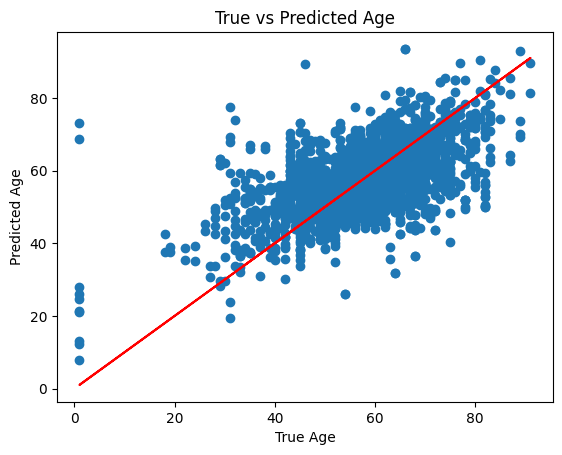

{'mae': 7.375522306321467, 'r2': 0.2842220664024353}
None


In [32]:
if TARGET_COLUMN == AGE_COLUMN:
    test_labels = clf.predict(test_X)
    test['pred'] = test_labels
else:
    test_prob = clf.predict_proba(test_X)[:,1]
    test_labels = np.where(test_prob > 0.5, np.ones_like(test_prob), np.zeros_like(test_prob))

    # save test predictions
    test['pred_prob'] = test_prob

test.to_csv(os.path.join(RESULTS_FOLDER, 'test_preds.csv'), index=False)

# compute evaluation metrics
metrics: dict = {}
if TARGET_COLUMN == AGE_COLUMN:
    metrics['r2'] = r2_score(test_y, test_labels)
    metrics['mae'] = mean_absolute_error(test_y, test_labels)
    # scatter plot of true vs predicted
    plt.scatter(test_y, test_labels)
    plt.xlabel('True Age')
    plt.ylabel('Predicted Age')
    plt.title('True vs Predicted Age')
    # also plot the learned line
    plt.plot(test_y, test_y, color='red')
    plt.show()
    confusion = None
else:
    metrics['accuracy'] = accuracy_score(test_y, test_labels)
    confusion = confusion_matrix(test_y, test_labels)
    metrics['auc'] = roc_auc_score(test_y, test_prob)

pprint(metrics)
pprint(confusion)